# E-commerce analysis: EDA.

## Setup

### Libraries

In [1]:
from datetime import timedelta
from zipfile import ZipFile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi

### Kaggle setup

In [2]:
api = KaggleApi()
api.authenticate()

### Retrieve data

In [3]:
api.dataset_download_file('carrie1/ecommerce-data', 'data.csv', 'raw_data')

False

In [4]:
with ZipFile('raw_data/data.csv.zip') as zf:
    zf.extractall('raw_data')

In [5]:
data = pd.read_csv(
    'raw_data/data.csv', 
    encoding='ISO-8859-1',
    parse_dates=['InvoiceDate']
)

## Data cleaning

### Manage null values

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
data[data['CustomerID'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [8]:
data[data['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


We have null values in two columns, we are going to fix them with different methods:

Description: we can use the stock code to find a sale of the same product and fill the missing description.
CustomerID: we can consider this sales as "guest sales" where we do not have an user because the user never logged in to buy. We will not delete them as those are still sales that generate value for analysis. We are going to keep them as nulls.

In [9]:
data[data['StockCode']=='84581'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1823,536544,84581,DOG TOY WITH PINK CROCHET SKIRT,1,2010-12-01 14:32:00,4.21,NaN,United Kingdom
7105,536988,84581,DOG TOY WITH PINK CROCHET SKIRT,1,2010-12-03 15:05:00,3.75,17238.0,United Kingdom
7694,537050,84581,DOG TOY WITH PINK CROCHET SKIRT,1,2010-12-05 11:10:00,3.75,14800.0,United Kingdom
13836,537434,84581,DOG TOY WITH PINK CROCHET SKIRT,1,2010-12-06 16:57:00,4.21,NaN,United Kingdom
16697,537666,84581,DOG TOY WITH PINK CROCHET SKIRT,1,2010-12-07 18:36:00,4.21,NaN,United Kingdom


In [10]:
stock_code_names = data.groupby('StockCode')['Description'].first().to_dict()

In [11]:
data['Description'] = data['StockCode'].map(stock_code_names)

### Remove inconsistent data 

We have sales with both units and value zero or negative, which is unexpected for sales data.

This might be returns that are even more important than sales.

Let's see this sales.

In [12]:
data.query('Quantity<=0').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [13]:
data.query('Quantity<=0').describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10624.000000,10624,10624.000000,8905.000000
mean,-45.607210,2011-06-24 19:32:09.346761984,42.308012,14991.667266
min,-80995.000000,2010-12-01 09:41:00,0.000000,12346.000000
25%,-10.000000,2011-03-24 11:23:15,1.060000,13510.000000
50%,-2.000000,2011-07-04 15:57:00,2.100000,14895.000000
75%,-1.000000,2011-10-06 19:52:00,4.950000,16393.000000
max,-1.000000,2011-12-09 11:58:00,38970.000000,18282.000000
std,1092.214216,NaN,623.481552,1706.772357


In [14]:
data.query('UnitPrice<=0').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,None,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,CHRISTMAS CRAFT HEART STOCKING,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NEW ENGLAND MUG W GIFT BOX,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,None,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


We do have multiple missing values on this cases,and as we do not have enough context I will proceed removing this registers.

If we had more context we could define a better approach, we could find the time from sale to return and even look into reasons for them.

In [15]:
data = data.query('UnitPrice>0 and Quantity>0')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


### Find outliers and classify them

array([[<Axes: title={'center': 'UnitPrice'}>,
        <Axes: title={'center': 'Quantity'}>]], dtype=object)

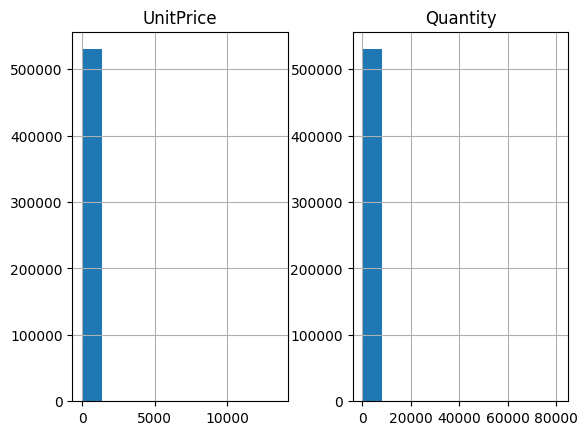

In [17]:
data[['UnitPrice', 'Quantity']].hist()

In [18]:
unit_top = data['UnitPrice'].quantile(0.999)
quantity_top = data['Quantity'].quantile(0.999)

In [19]:
data = data[data['UnitPrice']<=unit_top]
data = data[data['Quantity']<=quantity_top]

### Add utilitary columns


In [20]:
# utilitary date columns
data['transaction_date'] = data['InvoiceDate'].dt.date
data['date_month'] = data['InvoiceDate'].map(lambda dt: dt.date().replace(day=1))
data['month'] = data['InvoiceDate'].dt.month
data['date_week'] = data['InvoiceDate'].map(lambda dt: dt.date() + timedelta(days=-dt.weekday()))

In [21]:
# total value 
data['total_value'] = data['Quantity'] * data['UnitPrice']

## EDA: Exploratory data analysis

### Revenue 

#### Monthly

In [22]:
res = data.groupby('date_month')['total_value'].sum()

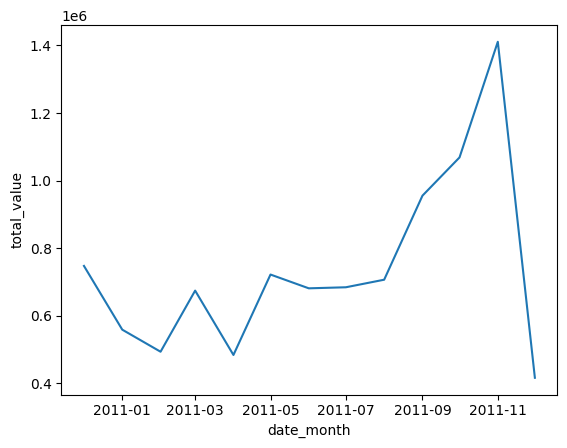

In [23]:
sns.lineplot(res)
plt.show()

#### Weekly

In [24]:
res = data.groupby('date_week')['total_value'].sum()

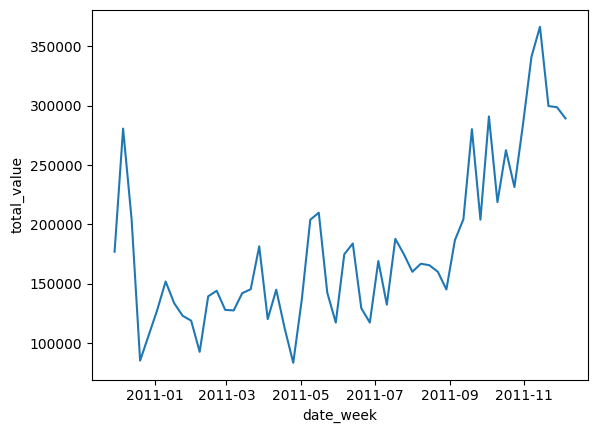

In [25]:
sns.lineplot(res)
plt.show()

### Number of sales

#### Monthly

In [26]:
res = data.groupby('date_month')['InvoiceNo'].count()

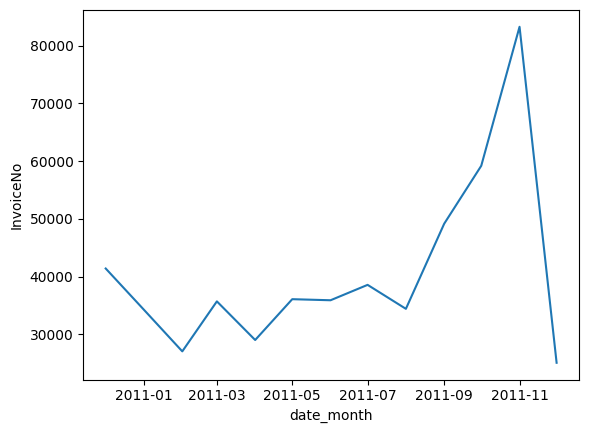

In [27]:
sns.lineplot(res)
plt.show()

#### Weekly

In [28]:
res = data.groupby('date_week')['InvoiceNo'].count()

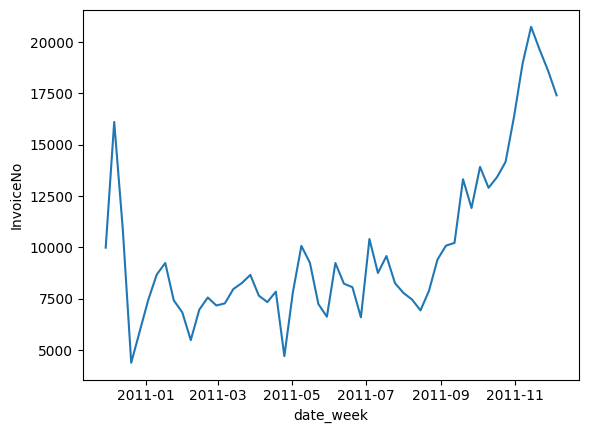

In [29]:
sns.lineplot(res)
plt.show()

### Product price variation over time

An interesting question is how much does prices vary each month, do we have periods of time where general prices increase or decrease?

In [30]:
mean_prices = data.groupby('StockCode')['UnitPrice'].mean()

In [31]:
mean_prices.head()

StockCode
10002     1.086620
10080     0.410909
10120     0.210000
10123C    0.650000
10124A    0.420000
Name: UnitPrice, dtype: float64

In [32]:
data['mean_price'] = data['StockCode'].map(mean_prices)

In [33]:
data['mean_price_dif'] = (data['UnitPrice']-data['mean_price'])/data['mean_price']

In [34]:
res = data.groupby('date_week')['mean_price_dif'].mean()

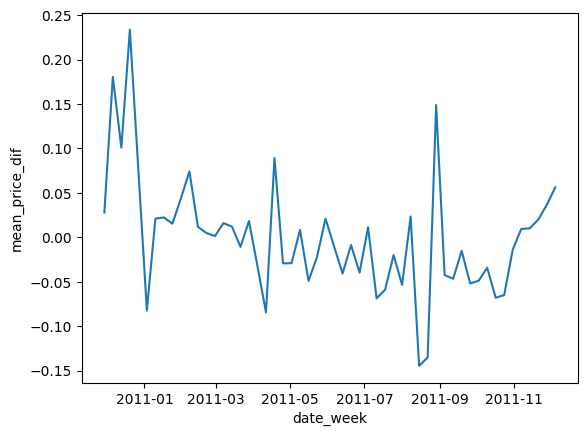

In [35]:
sns.lineplot(res)
plt.show()

We can see that prices increase mainly during november and december, expected due to christmas festivities.
Also interentigly enough the lowest prices are reported on august and september, so great if you have a birthday on those months you might get a good gift.

### Best seling products


In [36]:
res = data.groupby(['StockCode', 'Description'], as_index=False)[['Quantity', 'total_value']].sum()

#### By number of sales

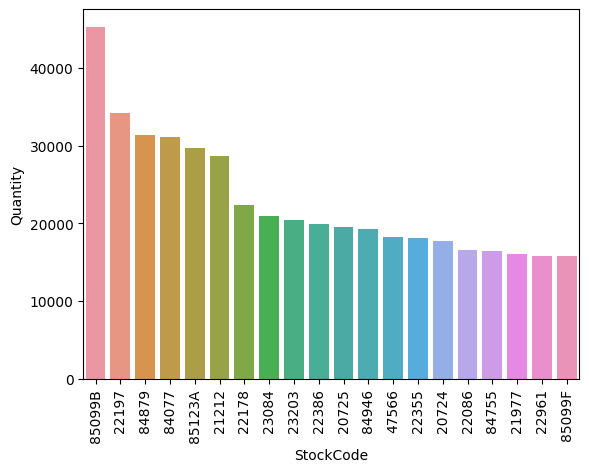

In [37]:
sns.barplot(
    res.sort_values('Quantity', ascending=False)[0:20],
    x='StockCode',
    y='Quantity'
)
plt.xticks(rotation = 90 )
plt.show()

#### 

In [38]:
res.sort_values('Quantity', ascending=False)[0:5]

,StockCode,Description,Quantity,total_value
3385,85099B,JUMBO BAG RED RETROSPOT,45274,88780.05
1109,22197,SMALL POPCORN HOLDER,34162,30555.53
3192,84879,ASSORTED COLOUR BIRD ORNAMENT,31413,51775.33
2907,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,31143,8770.17
3405,85123A,WHITE HANGING HEART T-LIGHT HOLDER,29698,82412.78


#### By revenue

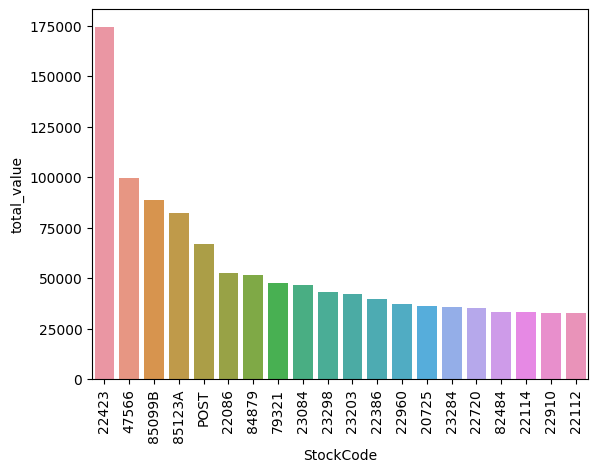

In [39]:
sns.barplot(
    res.sort_values('total_value', ascending=False)[0:20],
    x='StockCode',
    y='total_value'
)
plt.xticks(rotation = 90 )
plt.show()

In [40]:
res.sort_values('total_value', ascending=False)[0:5]

,StockCode,Description,Quantity,total_value
1310,22423,REGENCY CAKESTAND 3 TIER,13879,174484.74
2668,47566,PARTY BUNTING,18295,99504.33
3385,85099B,JUMBO BAG RED RETROSPOT,45274,88780.05
3405,85123A,WHITE HANGING HEART T-LIGHT HOLDER,29698,82412.78
3910,POST,POSTAGE,3142,67055.19


We can see that usually the top 5 are way above the rest of the products.

Two products are highlighted because the apper in both top 5:
* JUMBO BAG RED RETROSPOT
* WHITE HANGING HEART T-LIGHT HOLDER